# Classification Project

In [110]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [88]:
df=pd.read_csv('/Users/afsoon/Documents/Data/DataScienceRoadmap/spam_sms/spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [89]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df.columns=['label','Text']
df['label_enc'] = df['label'].map({'ham':0, 'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Exploratory Data Analysis

<AxesSubplot:xlabel='label_enc', ylabel='count'>

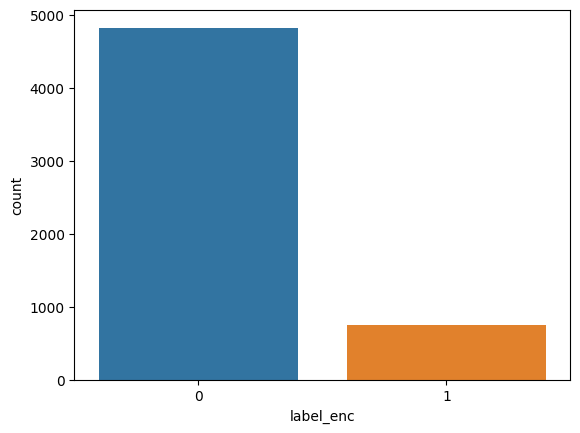

In [90]:
sns.countplot(x=df['label_enc'])

In [91]:
#Since I want to use embeddings in deep learning model, I don't need to balance the data

In [92]:
#Finding average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df.Text])/len(df.Text))
avg_words_len

15

In [93]:
# Finding Total number of unique words in corpus
total_words=[]
for sentence in df.Text:
    for word in sentence.split():
        if word not in total_words:
            total_words.append(word)
            total_words_len=len(total_words)

print(total_words_len)

15585


# Baseline Model Development

In [94]:
# Splitting data for Training and testing
X=df['Text']
y=df['label_enc']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [95]:
tfidf_vec=TfidfVectorizer()
tfidf_vec.fit(X_train)
X_train_vec=tfidf_vec.transform(X_train)
X_test_vec=tfidf_vec.transform(X_test)

In [96]:
baseline_model=MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

# Baseline Model Evaluation

In [97]:
accuracy_score(baseline_model.predict(X_test_vec),y_test)

0.9623318385650225

In [98]:
print(classification_report(baseline_model.predict(X_test_vec),y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1007
           1       0.72      1.00      0.84       108

    accuracy                           0.96      1115
   macro avg       0.86      0.98      0.91      1115
weighted avg       0.97      0.96      0.96      1115



<AxesSubplot:>

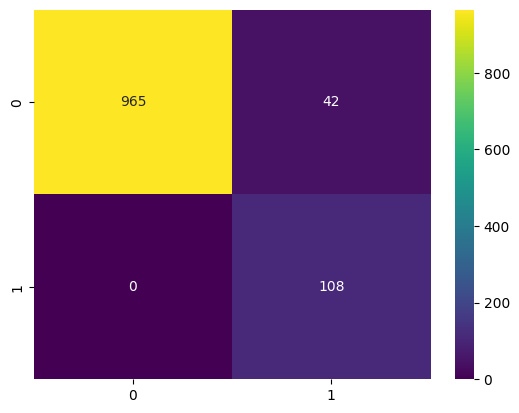

In [99]:
sns.heatmap(confusion_matrix(baseline_model.predict(X_test_vec),y_test),annot=True, fmt='d', cmap='viridis')

# Model 1: Creating custom Text vectorization and embedding layers

In [100]:
#Vectorizing the text 
text_vec = TextVectorization(
    max_tokens=total_words_len,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=avg_words_len)
# Adapting the text vectorization layer to the X_train
text_vec.adapt(X_train)

In [101]:
X_train_processed = text_vec(X_train)
X_test_processed = text_vec(X_test)
X_train_processed

<tf.Tensor: shape=(4457, 15), dtype=int64, numpy=
array([[  40,   24,    9, ...,   11,   55,   19],
       [ 807,   15, 3167, ..., 1892, 2919, 1979],
       [ 110,   88, 1491, ...,    0,    0,    0],
       ...,
       [2075, 2008,  252, ...,    0,    0,    0],
       [ 773, 1739, 1083, ...,    0,    0,    0],
       [   9,  147,   23, ...,    0,    0,    0]])>

In [102]:
#Testing the text_vec
sample_sentence= 'This is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [103]:
#Building the Sequential Model
model1=keras.Sequential()
model1.add(layers.Embedding(input_dim=total_words_len, output_dim=128,
                            input_length=avg_words_len, embeddings_initializer='uniform'))
model1.add(layers.GlobalAveragePooling1D())
model1.add(layers.Flatten())
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [104]:
#Print the model summary
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d_6   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,999,041
Trainable params: 1,999,041
Non-trainable params: 0
___________________________________________

In [105]:
#Compiling the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
#Training the model
history1=model1.fit(X_train_processed, y_train, validation_data=(X_test_processed, y_test), epochs=5)

Epoch 1/5
140/140 [==============================] - 1s 7ms/step - loss: 0.3183 - accuracy: 0.8977 - val_loss: 0.1337 - val_accuracy: 0.9650
Epoch 2/5
140/140 [==============================] - 1s 6ms/step - loss: 0.0705 - accuracy: 0.9807 - val_loss: 0.0819 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 1s 6ms/step - loss: 0.0290 - accuracy: 0.9924 - val_loss: 0.0789 - val_accuracy: 0.9803
Epoch 4/5
140/140 [==============================] - 1s 6ms/step - loss: 0.0130 - accuracy: 0.9966 - val_loss: 0.0812 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 1s 6ms/step - loss: 0.0067 - accuracy: 0.9989 - val_loss: 0.0845 - val_accuracy: 0.9821


In [109]:
history1.history

{'loss': [0.3182542324066162,
  0.07048259675502777,
  0.028957471251487732,
  0.012978384271264076,
  0.006728057749569416],
 'accuracy': [0.8976890444755554,
  0.9807044863700867,
  0.9923715591430664,
  0.9966344833374023,
  0.9988781809806824],
 'val_loss': [0.1337113380432129,
  0.0819028839468956,
  0.0789005383849144,
  0.08116059750318527,
  0.0844932347536087],
 'val_accuracy': [0.9650224447250366,
  0.9757847785949707,
  0.9802690744400024,
  0.9802690744400024,
  0.9820627570152283]}

<AxesSubplot:>

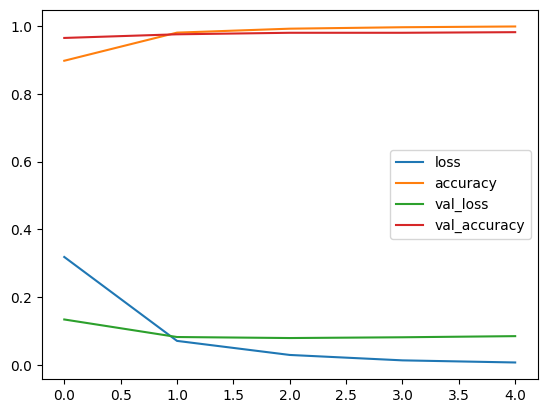

In [107]:
pd.DataFrame(history1.history).plot()

In [114]:
#Creating helper functions for compiling, fitting, and evaluating the model performance

def compile_model(model):
    ''' 
    simply compile the model with adam optimzer 
    '''
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    ''' 
    fit the model with given epochs, train  
    and test data 
    '''
    history=model.fit(X_train, y_train, 
                      validation_data=(X_test, y_test),
                      validation_steps=int(0.2*len(X_test)), 
                      epochs=epochs)
    return history

def evaluate_model(model, X, y): 
    ''' 
    evaluate the model and returns accuracy,  
    precision, recall and f1-score  
    '''
    y_preds = np.round(model.predict(X)) 
    accuracy = accuracy_score(y, y_preds) 
    precision = precision_score(y, y_preds) 
    recall = recall_score(y, y_preds) 
    f1 = f1_score(y, y_preds) 
  
    model_results_dict = {'accuracy': accuracy, 
                          'precision': precision, 
                          'recall': recall, 
                          'f1-score': f1} 
  
    return model_results_dict

# Model 2: Bidirectional LSTM

# Model 3: Transfer Learning with USE Encoder